In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal as sig
from scipy.fftpack import fft
from scipy import interpolate
from math import pi

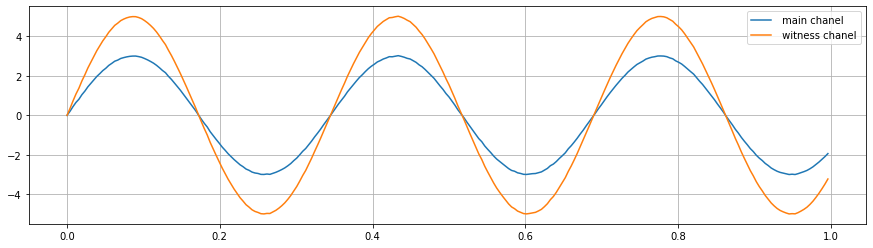

In [2]:
T = 3600
Sample_rate= 256
SegmentDuration = 100
N = T*Sample_rate
t = np.arange(N)/Sample_rate
N0 = 0.01
freq = 2.9
# Original Signal
c=np.sin(2*pi*freq*t)

#Noise
noise = np.random.normal(0,N0,N) 

#Main chanel
x = 3.0*c+noise

#Witness chanel
y = 5.0*c+noise
plt.figure(figsize=(15,4))
plt.plot(t[0:Sample_rate],x[0:Sample_rate] , label=r' main chanel')
plt.plot(t[0:Sample_rate],y[0:Sample_rate] , label=r' witness chanel')
plt.legend()
plt.grid()

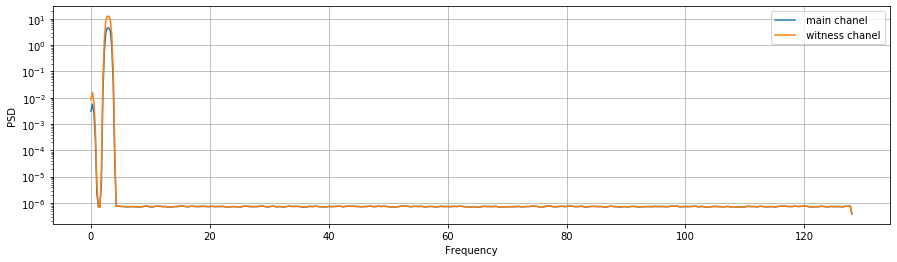

In [3]:
#Amplitude spectrum
f1 , psdx = sig.welch(x,Sample_rate,'flattop',1024,scaling='spectrum')
f2 , psdy = sig.welch(y,Sample_rate,'flattop',1024,scaling='spectrum')
plt.figure(figsize=(15,4))
plt.semilogy(f1,psdx, label=r' main chanel')
plt.semilogy(f1,psdy, label=r' witness chanel')
plt.xlabel('Frequency')
plt.ylabel('PSD')
plt.grid()
plt.legend()

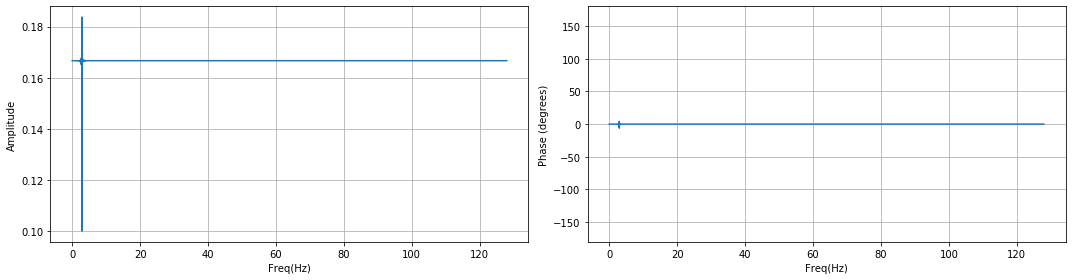

In [6]:
#Wiener filter
Seg_Wiener = 6
x_wiener = x[0:SegmentDuration*Sample_rate*Seg_Wiener]
y_wiener = y[0:SegmentDuration*Sample_rate*Seg_Wiener]

for i in range(Seg_Wiener):
    ind1 = i*SegmentDuration*Sample_rate
    ind2 = (i+1)*SegmentDuration*Sample_rate
    tmpx = x_wiener[ind1:ind2]
    tmpy = y_wiener[ind1:ind2]
    if i==0:
        T_f = np.fft.rfft(sig.hann(len(tmpx))*tmpx)/np.fft.rfft(sig.hann(len(tmpy))*tmpy)
    else:
        T_f = np.fft.rfft(sig.hann(len(tmpx))*tmpx)/np.fft.rfft(sig.hann(len(tmpy))*tmpy)
T_f = T_f/Seg_Wiener

freq = np.fft.rfftfreq(SegmentDuration*Sample_rate,d=1./Sample_rate)

#Coherence Cut
f ,cohsignal = sig.coherence(x_wiener,y_wiener,fs=Sample_rate,window='hann',nperseg=SegmentDuration*Sample_rate)
#cohThreshold = 0.01
#T_f[cohsignal > cohThreshold] = 0

#Plot Filter
plt.figure(figsize=(15,4))

plt.subplot(121)
plt.plot(freq, np.abs(T_f))
plt.grid()
plt.xlabel('Freq(Hz)')
plt.ylabel('Amplitude')

plt.subplot(122)
plt.plot(freq, np.angle(T_f,deg=True))
plt.grid()
plt.ylim(-180,180)
plt.xlabel('Freq(Hz)')
plt.ylabel('Phase (degrees)')
plt.tight_layout()

/home/ishanjo/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/ishanjo/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


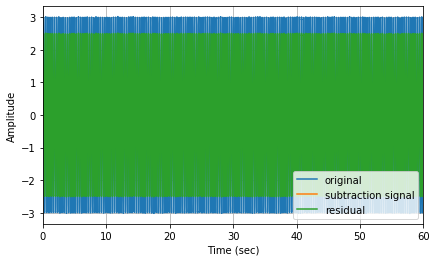

In [7]:
#Wiener Subtraction
tmp = np.fft.irfft(T_f)
tmp_len = len(tmp)
tmp = sig.hann(tmp_len)*np.roll(tmp, np.int(tmp_len/2))
tmp.resize(len(y)) # pad with zeros to lenght of witness
T_f_long = np.fft.rfft(np.roll(tmp,-np.int(tmp_len/2)))
T_f_interpolate = interpolate.interp1d(freq,T_f)
freq1 = np.fft.rfftfreq(len(y),d=1./Sample_rate)
T_f_long = T_f_interpolate(freq1)
tmp = np.fft.rfft(y)*T_f_long
est_subtract = np.fft.irfft(tmp)
res = x-est_subtract
#Plot
plt.figure(figsize=(15,4))

plt.subplot(121)
plt.plot(t,x,label='original')
plt.plot(t,est_subtract,label='subtraction signal')
plt.plot(t,res,label='residual')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.xlim(0,60)
plt.grid()
plt.legend()
